# Example of reading, visualizing and analizing data from Eulag fort.11
<hr />

In [1]:
# use external libraries in Jupyter
import sys
#sys.path.append('/Users/pachocamacho/python_beta_eulag') #Use only once to add your path
sys.path

['',
 '/Users/pachocamacho/python_beta_eulag',
 '/Users/pachocamacho/anaconda3/envs/ipykernel_py3/lib/python36.zip',
 '/Users/pachocamacho/anaconda3/envs/ipykernel_py3/lib/python3.6',
 '/Users/pachocamacho/anaconda3/envs/ipykernel_py3/lib/python3.6/lib-dynload',
 '/Users/pachocamacho/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages',
 '/Users/pachocamacho/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/aeosa',
 '/Users/pachocamacho/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/IPython/extensions',
 '/Users/pachocamacho/.ipython']

##### Loading libraries and reading: file and grid __*(f11_dat, grid)*__
<hr />

In [2]:
#update changes
%load_ext autoreload
%autoreload 2
# import standard libraries
import numpy as np
import matplotlib.pyplot as plt
from pylab import *
# import custom libraries for eulag
import cart_grid as gd
import FileReader as fr

#data = gd.read_files() # read mylist.nml and ee.txt
Grid = gd.read_params() # get grid parameters
Grid.help # see parameters imported in object

f11_dat = fr.read_f11(Grid) # read fort.11 file

ee.txt file OK
mylist.nml file OK
EULAG grid parameters:
(it,n,m,l) =  123000 128 128 175
(Lx,Ly,Lz,dt) =  5.0 5.0 4.0 0.003
see attributes with self.help 
# of outputs in fort.11 file:  61
temporal slices to consider : 0 to 61
Skipping data from first records of fort.11 ...
Reading data from file fort.11 ...
number of outputs =  61
DONE


In [3]:
print(f11_dat.keys()) # structure of fort.11 data imported
print(np.shape(f11_dat['u'])) # sample variable shape

dict_keys(['u', 'v', 'w', 't', 'p', 'bx', 'by', 'bz'])
(61, 128, 128, 175)


##### Import library for use of physical units _**(create object units)**_
<hr/>

In [4]:
from units import *
units = read_units()
units.l_0

time-scale     =  1341.640786499874  [s]
velocity scale =  7.453559924999299  [Km / s]
B field scale  =  0.00013211090992020037  [kT]


10.0

##### Import library to convert fields and grid to physical units
<hr/>

In [5]:
import physical as ph
phyf11_dat = ph.phy_vars(f11_dat) # vars in physical units
pgrid = ph.read_phygrid() # create physical grid

time-scale     =  1341.640786499874  [s]
velocity scale =  7.453559924999299  [Km / s]
B field scale  =  0.00013211090992020037  [kT]
ee.txt file OK
mylist.nml file OK
EULAG grid parameters:
(it,n,m,l) =  123000 128 128 175
(Lx,Ly,Lz,dt) =  5.0 5.0 4.0 0.003
pressure not transformed !
working ...
DONE


In [6]:
# Optional rolling option - customizable according to the run results
# (needed only when the spot is displaced from the center)
from roll import *
phyf11_dat = rolling(phyf11_dat,66,1)

rolling fields ...
DONE


#### Import plotting libraries and make some plots
<hr/>

In [7]:
# import standard library for plotting
import matplotlib.pyplot as plt
%matplotlib inline
# import custom library for slice plot of eulag data
import plot_tools as pt
prefs = pt.plot_mode() # set preferences of slice plot

time-scale     =  1341.640786499874  [s]
velocity scale =  7.453559924999299  [Km / s]
B field scale  =  0.00013211090992020037  [kT]
max/min scale from slice 0.2 / -0.2


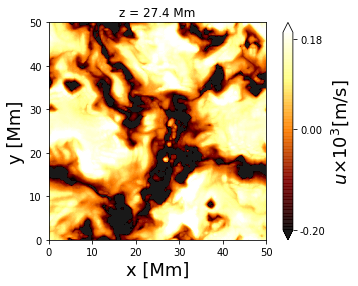

In [8]:
pt.plt_boxsl(pgrid,Grid,phyf11_dat['puz'],1,prefs,44)

time-scale     =  1341.640786499874  [s]
velocity scale =  7.453559924999299  [Km / s]
B field scale  =  0.00013211090992020037  [kT]
max/min scale from slice 0.2 / -0.2


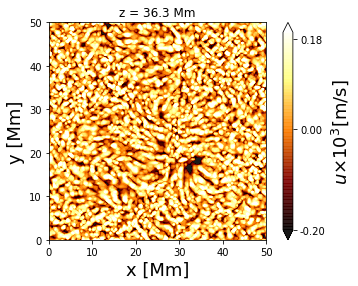

In [9]:
# modify slice location and plot again
prefs.cut = 159
pt.plt_boxsl(pgrid,Grid,phyf11_dat['puz'],1,prefs,44)

time-scale     =  1341.640786499874  [s]
velocity scale =  7.453559924999299  [Km / s]
B field scale  =  0.00013211090992020037  [kT]
max/min scale from slice 0.03 / -0.03


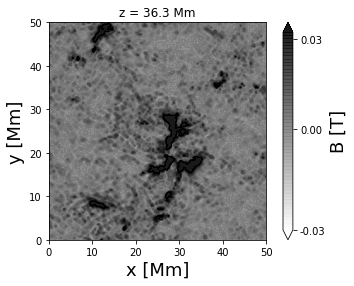

In [14]:
# plot different variable
prefs.cut = 159
pt.plt_boxsl(pgrid,Grid,phyf11_dat['pbz'],4,prefs,44)

#### *Calculation of turbulent heat correlation*
<hr/>
Following an approach similar to [Kitchatinov & Mazur (2011)](https://link.springer.com/article/10.1023/A:1005213708194), we compute the radial turbulent heat flux, $F_r$, as follows:
\begin{equation}
    F_r = -\overline{u_r'T'}
\end{equation}
where the average is taken in the $x$ direction only. In the anelastic approximation we consider $u_r'$ and $T'$ as the perturbations of radial velocity and temperature around an ambient state defined in EULAG-MHD. The usual anelastic approximation gives: 
\begin{equation}
    T' \sim \frac{T_e}{\theta_e} \theta'
\end{equation}
where the subscript "e" denotes the profiles of the ambient state. Replacing the relation above into the formula for $F_r$ gives:
\begin{equation}
    F_r = - \left(\frac{T_e}{\theta_e}\right) \overline{u_r' \theta'}
\end{equation}

#### *Import utility libraries for analisis and visualization of turbulent heat correlations:*
<hr/>

In [15]:
from turb_corr import *
wtp = uth_eddy(phyf11_dat,Grid,units)

calculating turbulent heat correlations ... 
DONE.


max/min values =  0.8 -0.8


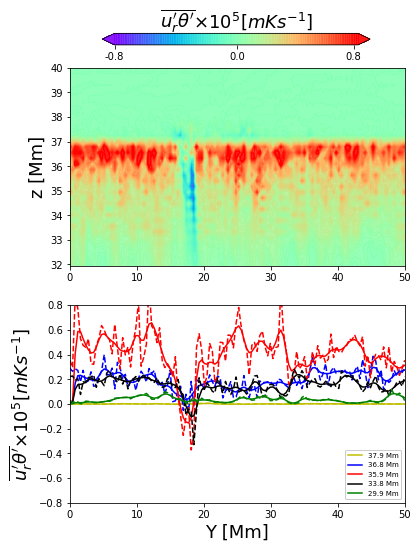

In [16]:
from plot_uth import *
g1 = plt_uth(wtp,pgrid,Grid,units)

#### *Calculation of turbulent heat conductivity*
<hr/>
We compute the turbulent heat conductivity, $\chi_T$, following [Kapÿlä *et.al* (2011)](https://arxiv.org/abs/1010.1250):
\begin{equation}
    \chi_T = -\frac{c_p \overline{u_r'T'}}{\overline{T}
    \nabla_r\overline{S}} = -\frac{c_p F_r}{\overline{T}
    \nabla_r\overline{S}}
\end{equation}
Here, we identify $\overline{T} = T_e$ and $\overline{S} = S_e$. In the anelastic approximation we also use:
\begin{equation}
    \theta = T \left(\frac{P_0}{P}\right)^{R_g/c_p}
\end{equation}
and replacing all into the formula for $\chi_T$, we get: 
\begin{equation}
    \chi_T = -\frac{F_r}{\theta_e\partial_r\left(\log{\theta_e} \right)}
\end{equation}

In [12]:
X_t = x_eddy(phyf11_dat,Grid,units)

calculating turbulent heat conductivity
calculating turbulent heat correlations ... 
DONE.


max/min values =  2.0 -0.5


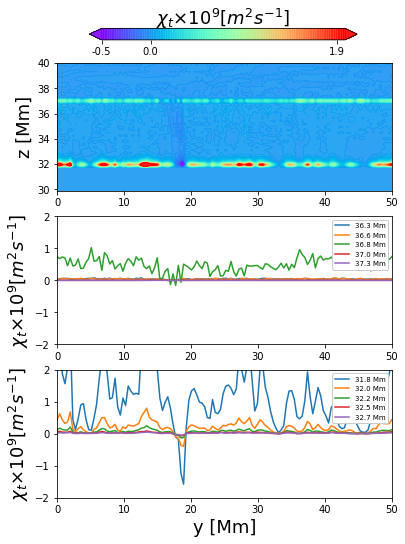

In [18]:
from plot_Xt import *
plt_Xt(X_t,pgrid,Grid,units)

#### *Calculation of Nempi coefficients*
<hr/>
Following an approach similar to [Käpylä et.al. (2016)](https://link.springer.com/article/10.1023/A:1005213708194), we compute the coefficient $Q_p$ that parameterizes the effects of turbulence in the effective magnetic pressure as follows:

\begin{equation}
    P_{eff} = \frac{1}{2}\left(1-Q_p \right) \beta^2
\end{equation}

where $\beta = \langle \mathbf{B} \rangle^2/B_{eq}$, and the equipartition field is computed as:

\begin{equation}
    B_{eq} = \sqrt{\langle \mu_0 \rho \bf{u}^2\rangle}
\end{equation}

<hr/>

We consider the total turbulent stress in the momentum equation, given as:

\begin{equation}
    \Pi_{ij}^{(f)} = \langle \rho u_i u_j \rangle + \delta_{ij} \frac{\langle \mathbf{b} \rangle^2 }{ 2\mu_0}              - \frac{\langle b_i b_j \rangle}{2 \mu_0}
\end{equation}

and we take $\Pi_{ij}^{(f,0)}$ and $\Pi_{ij}^{(f,\mathbf{B})}$ as the stress tensors values with and without the presence of an external mean magnetic field $\langle \mathbf{B} \rangle$, respectively. Their difference $\Delta \Pi_{ij}^{(f)} = \Pi_{ij}^{(f,\mathbf{B})} - \Pi_{ij}^{(f,0)}$ is parameterized by: 

\begin{equation}
    \Delta \Pi_{ij}^{(f)} = \frac{1}{\mu_0} \left( Q_s \langle B_i \rangle \langle B_j \rangle - 
                \frac{1}{2}Q_p\delta_{ij} \langle \mathbf{B} \rangle^2 - Q_g \langle \hat{g_i} \rangle \langle 
                \hat{g_j} \rangle \langle \mathbf{B} \rangle^2 \right)
\end{equation}

where $\hat{g_i}$ is the unit vector along the direction of gravity. Now, we take $(i,j) = (x,x)$ in the previous equation from which we get:

\begin{equation}
Q_p = -2 \mu_0 \frac{\Delta \Pi_{xx}^{(f)}}{\langle \mathbf{B} \rangle^2}
\end{equation}
<hr/>
For the calculations we consider two types of averaging to compare results with other papers. First we take an average along one axis (usually x axis) which is taken along a sheet containing only the magnetic structure of interest. The corresponding Nempi coefficient obtained this way is denoted as $\left(Q_p\right)^x \rightarrow f(y,z)$. The other average is a standard horizontal mean over the xy plane and the corresponding Nempi coefficient is denoted as $\left(Q_p \right)^{xy} \rightarrow f(z)$. 

In [17]:
from turb_corr import *
# one-axis mean (2) 
corrs, m_set = MR_corrs(phyf11_dat,Grid,units,2)
# horizontal mean (1)
xy_corrs, xy_set = MR_corrs(phyf11_dat,Grid,units,1)

calculating turbulent correlations ... 
DONE
calculating turbulent correlations ... 
DONE


In [20]:
qp = nempi_qp(phyf11_dat,corrs,m_set,Grid,units,2)
xy_qp = nempi_qp(phyf11_dat,xy_corrs,xy_set,Grid,units,1)
print(qp.shape)
print(xy_qp.shape)

computing coefficients ... 


/Users/pachocamacho/python_beta_eulag/turb_corr.py:216: RuntimeWarning: divide by zero encountered in true_divide
  np.multiply(mb[tt,:,:],mb[tt,:,:]))
/Users/pachocamacho/python_beta_eulag/turb_corr.py:216: RuntimeWarning: invalid value encountered in true_divide
  np.multiply(mb[tt,:,:],mb[tt,:,:]))


DONE
computing coefficients ... 


/Users/pachocamacho/python_beta_eulag/turb_corr.py:220: RuntimeWarning: invalid value encountered in true_divide
  np.multiply(mb[tt,:],mb[tt,:]))


DONE
(61, 128, 175)
(61, 175)


max/min values =  2 -5


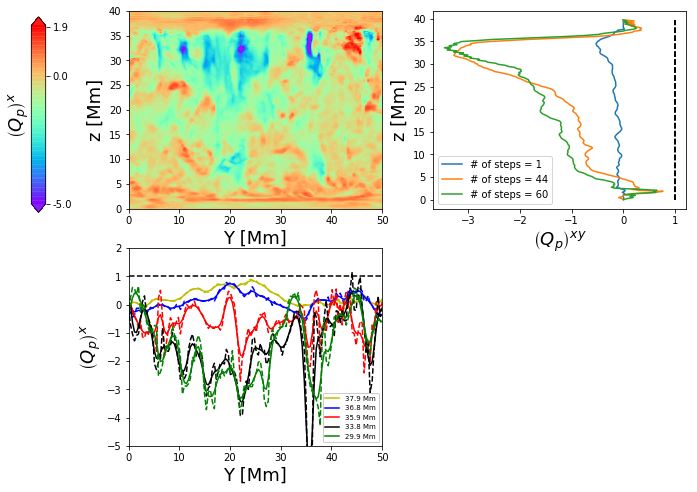

In [19]:
# here we compute profiles of Q_p 
# obtained by the two types of averaging
from plot_nempi import *
g2 = plt_nempi(qp,xy_qp,pgrid,Grid,units)